In [8]:
import tensorflow as tf
import numpy as np
from time import time
from datetime import datetime
import os
import sys
import math
import tensorflow as tf
import numpy as np
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)
tf.random.set_seed(42)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
# Type = 'Volterra'
Type = 'Fredholm'
N_r = 32

def gamma_tf(x):
    return tf.exp(tf.math.lgamma(x))
    
if Type == 'Fredholm':
    xmin = -pi/2.
    xmax = pi/2.
    tmin = -pi/2
    tmax = pi/2
    t_dummy = tf.linspace(tmin, tmax, N_r)
    t_dummy = tf.reshape(t_dummy, (-1,1))
    t_dummy = tf.convert_to_tensor(t_dummy, dtype=tf.float32)
    alpha = 1. # Integral order
else:
    xmin = 0.
    xmax = 1.
    t_dummy = []
    alpha = 0.5 # Fractional integral order

lb = [xmin]
ub = [xmax]

x_r_f=np.linspace(lb[0], ub[0], N_r)
X_r=np.reshape(x_r_f, (-1,1))
X_r = tf.convert_to_tensor(X_r, dtype=tf.float32)
h = (xmax - xmin)/(N_r - 1)

In [9]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model"""
    def __init__(self,
            output_dim=1,
            num_hidden_layers=3, 
            num_neurons_per_layer=16,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [10]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        self.X_r = X_r
        self.hist = []
        self.iter = 0
        self.last_n_losses = []
        self.t_dummy = t_dummy
    # Function to access the last n loss for early stopping
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)
            
    # Function to return the max relative error in the last 20 iterations        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number
        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
        
    # The fractional integral/derivative in the Riemann-Liouville sense. A negative alpha corresponds to differentiation.
    def RL(self, alpha, f, data_point):
        summation = 0.
        for k in range(data_point+1):
            if k==0 and data_point != 0:
                sigma = (1 + alpha)*data_point**alpha - data_point**(1. + alpha) + (data_point - 1.)**(1. + alpha)
            elif k==data_point:
                sigma = 1.
            elif 0<k<data_point:
                sigma = (data_point - k + 1.)**(1. + alpha) - \
                2.*(data_point - k)**(1. + alpha) + (data_point - k - 1.)**(1. + alpha)
            summation += sigma*(f[k])
        fractional = h**(alpha) * 1./gamma_tf(2. + alpha)*summation
        return fractional

    # Function to calculate FIDE terms and BC losses (if needed)
    def get_r(self):
        #Access relevant integer-order derivatives using AD
        with tf.GradientTape() as tape:
            tape.watch(self.X_r)
            u = self.model(self.X_r)            
        u_x = tape.gradient(u, self.X_r)
        del tape
        
        if Type == 'Volterra': # Calculate Volterra-type integrals
            uf = []
            for index in range(0, len(X_r)):
                XD = X_r[:index]
                X = X_r[index]
                u = self.model(XD)
                integrand = u
                uf_pw = self.RL(alpha, integrand, index-1)
                if index == 0:
                    uf_pw = [0.]
                uf = tf.concat([uf, [uf_pw[0]]], axis=0)
            uf = tf.reshape(uf, (-1,1))
            u = self.model(X_r)
            res = u - (tf.sqrt(pi)*(1. + X_r)**-1.5 - 0.02*X_r**3/(1. + X_r) + 0.01*X_r**2.5*uf)
            loss_r = tf.reduce_mean(tf.square(res))
            loss = loss_r # No BC loss is needed for this problem
            
        else: # Calculate Fredholm-type integrals
            u_dummy = self.model(self.t_dummy)
            uf = [self.RL(alpha, self.t_dummy*u_dummy**2, index) for index in range (N_r - 1, N_r)][0]
            res = u_x - (tf.cos(self.X_r) - X_r + 0.25*X_r*uf)
            loss_r = tf.reduce_mean(tf.square(res))
            loss_bc = tf.reduce_mean(tf.square(self.model(-pi/2.*tf.ones(tf.shape(self.X_r))) - (0.)))
            loss = loss_r + loss_bc
        return loss
        
    # Accessing loss values from get_r()
    def loss_fn(self):
        loss_eq = self.get_r()
        loss = loss_eq
        return loss
        
    # Calculating the grad of loss w.r.t. the trainable variables
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape       
        return loss, g
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad()
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):          
            loss = train_step()
            self.current_loss = loss.numpy()
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error)
            self.update_last_n_losses(self.current_loss)

            if self.max_relative_error < 1e-3: # in %
                tf.print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break
  
    def callback(self, xr=None):
        if self.iter % 2000 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [11]:
model = PINN_NeuralNet()
model.build(input_shape=(None,1))
solver = PINNSolver(model, X_r)
if 'runtime' in globals():
    del runtime
try:
    runtime
except NameError:
    runtime = 0.

In [12]:
try:
    t0 = time()
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,2000],[1e-2,5e-3,1e-3])
    optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, N=int(3e4+1))
    runtime += (time()-t0)
    print('\nRuntime: {:.3f} seconds'.format(runtime))
except KeyboardInterrupt:
    runtime += (time()-t0)
    print('\nRuntime: {:.3f} seconds'.format(runtime))

It 00000: loss = 1.74670982e+00
It 02000: loss = 4.48647188e-05
It 04000: loss = 2.52085883e-05
It 06000: loss = 9.74814157e-06
It 08000: loss = 3.47476043e-06
It 10000: loss = 1.09002360e-06
It 12000: loss = 4.95412905e-07
It 14000: loss = 3.21581638e-07
It 16000: loss = 1.53186534e-06
It 18000: loss = 2.59076455e-06
It 20000: loss = 2.21877826e-07
It 22000: loss = 2.20645902e-07
It 24000: loss = 7.35222284e-06
It 26000: loss = 1.96696519e-07
It 28000: loss = 2.03148659e-07
It 30000: loss = 1.93173037e-07

Runtime: 9.412 seconds


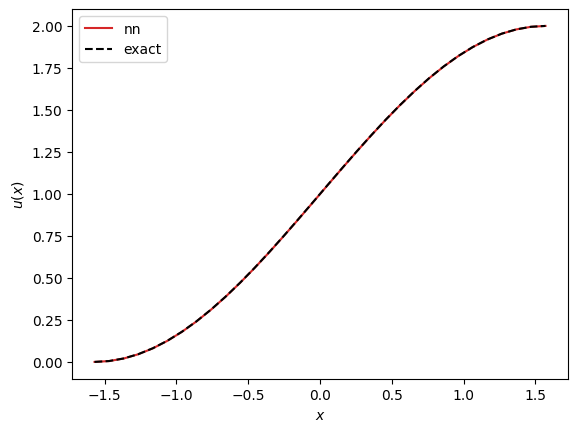

In [13]:
x_r_f=np.linspace(lb[0], ub[0], N_r)
X_r=np.reshape(x_r_f, (-1,1))
X_r = tf.convert_to_tensor(X_r, dtype=tf.float32)
y_pred = model(X_r)
if Type == 'Volterra':
    y_e = tf.sqrt(pi)*(1. + X_r)**-1.5
else:
    y_e = 1. + tf.sin(X_r)

plt.plot(X_r, y_pred, label='nn', color='tab:red')
plt.plot(X_r, y_e, linestyle='--', label='exact', color='k')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend()

<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

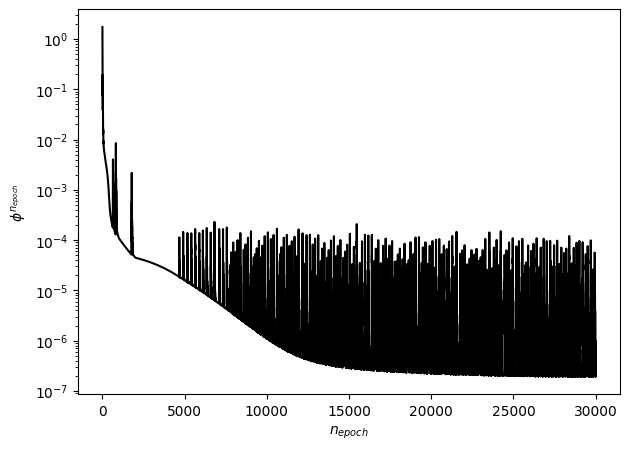

In [14]:
solver.plot_loss_history()